# Memory access

Useful resources: https://github.com/mitmath/18S096/blob/master/lectures/lecture4/memory.pdf and https://github.com/mitmath/18S096/blob/master/lectures/lecture4/memory-matrices.ipynb

## CPU specs

The built-in `versioninfo()` can be used to obtain the CPU model and the processor base frequency. If we want more information, we can use the package [CpuId.jl](https://github.com/m-j-w/CpuId.jl).

(Of course, we could also take a look at the [Intel specification of the i5-6600](https://ark.intel.com/content/www/de/de/ark/products/88188/intel-core-i5-6600-processor-6m-cache-up-to-3-90-ghz.html))

In [207]:
using CpuId
cpuinfo()

| Cpu Property       | Value                                                      |
|:------------------ |:---------------------------------------------------------- |
| Brand              | Intel(R) Core(TM) i5-6600 CPU @ 3.30GHz                    |
| Vendor             | :Intel                                                     |
| Architecture       | :Skylake                                                   |
| Model              | Family: 0x06, Model: 0x5e, Stepping: 0x03, Type: 0x00      |
| Cores              | 4 physical cores, 4 logical cores (on executing CPU)       |
|                    | No Hyperthreading detected                                 |
| Clock Frequencies  | 3300 / 3900 MHz (base/max), 100 MHz bus                    |
| Data Cache         | Level 1:3 : (32, 256, 6144) kbytes                         |
|                    | 64 byte cache line size                                    |
| Address Size       | 48 bits virtual, 39 bits physical                          |
| SIMD               | 256 bit = 32 byte max. SIMD vector size                    |
| Time Stamp Counter | TSC is accessible via `rdtsc`                              |
|                    | TSC runs at constant rate (invariant from clock frequency) |
| Perf. Monitoring   | Performance Monitoring Counters (PMC) revision 4           |
|                    | Available hardware counters per logical core:              |
|                    | 3 fixed-function counters of 48 bit width                  |
|                    | 8 general-purpose counters of 48 bit width                 |
| Hypervisor         | No                                                         |


We see that this machine is part of the Skylake family and supports **SIMD (Single Instructions Multiple Data)**. Concretely, registers are 256 bit/32 byte wide and 4 double precision floating point numbers (`Float64`) can be processed in each FMA unit. We can check explicitly that AVX2 instructions are available:

In [211]:
:AVX2 in cpufeatures() # alternatively, cpufeaturetable()

true

From the table above, we see that the L1, L2, and L3 cache sizes are 32 KB, 256 KB, and 6144 KB:

In [220]:
cachesize()

(32768, 262144, 6291456)

## Cache topology

In [224]:
import Hwloc
Hwloc.topology_load()

D0: L0 P0 Machine  
    D1: L0 P-1 Package  
        D2: L0 P-1 L3Cache  Cache{size=6291456,depth=3,linesize=64,associativity=12,type=Unified}
            D3: L0 P-1 L2Cache  Cache{size=262144,depth=2,linesize=64,associativity=4,type=Unified}
                D4: L0 P-1 L1Cache  Cache{size=32768,depth=1,linesize=64,associativity=8,type=Data}
                    D5: L0 P-1 Core  
                        D6: L0 P0 PU  
            D3: L1 P-1 L2Cache  Cache{size=262144,depth=2,linesize=64,associativity=4,type=Unified}
                D4: L1 P-1 L1Cache  Cache{size=32768,depth=1,linesize=64,associativity=8,type=Data}
                    D5: L1 P-1 Core  
                        D6: L1 P1 PU  
            D3: L2 P-1 L2Cache  Cache{size=262144,depth=2,linesize=64,associativity=4,type=Unified}
                D4: L2 P-1 L1Cache  Cache{size=32768,depth=1,linesize=64,associativity=8,type=Data}
                    D5: L2 P-1 Core  
                        D6: L2 P2 PU  
            D3: L3 P-1 L2C

<img src="memory_access_caches.png" width=500px style="float: left">

(Created with `lstopo` included in [hwloc](https://www.open-mpi.org/projects/hwloc/).)

## Microarchitecture: How many FMA/MUL/Add units?

We can consult the [Intel® 64 and IA-32 Architectures
Optimization Reference Manual
](https://software.intel.com/sites/default/files/managed/9e/bc/64-ia-32-architectures-optimization-manual.pdf) to get an impression of the Skylake microarchitecture:

<img src="memory_access_skylake_cpu.png" width=700px style="float: left">

We see that a core has **2 FMA/Add/MUL units** and **2 LD/STA (Load/Store address)**.

# `vecmul!`

In [12]:
function vecmul!(c,a,b)
    @assert length(a) == length(b) == length(c)
    n = length(c)
    @inbounds for i in 1:n
        c[i] = a[i] * b[i]
    end
    return c
end

vecmul(A, B) = vecmul!(Vector{promote_type(eltype(A), eltype(B))}(undef, length(A)), A, B)

vecmul (generic function with 1 method)

In [233]:
# correctness check:
using LinearAlgebra
a = rand(5)
b = rand(5)
vecmul(a,b) - a .* b

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

#### Upper performance bound estimate: $P_{max}$

In [257]:
cycles_per_s = cpu_max_frequency() * 1e-3 # 3.9 GHz, assume turbo clock frequency
cycles_necessary = 3 # 3 LOAD, 1 STORE, 1 MUL 
fma_per_cycle = 2/cycles_necessary
flops_per_fma = 4
flops_per_cycle = flops_per_fma * fma_per_cycle
ncores = 1 # used cores

P_max = cycles_per_s * flops_per_cycle * ncores # Gflops/s

10.399999999999999

#### Benchmark

In [14]:
using BenchmarkTools
N = round.(Int, exp10.(range(1, log10(1_000_000), length=500)))  # 100 sizes from 10 to 3000
t = Float64[]
@time for n in N
    a = fill(1.2, n)
    b = fill(0.8, n)
    c = zeros(n)
    push!(t, @belapsed vecmul!($c,$a,$b))
    println("finished n = $n, time: ", t[end], " flops/t: ", n/t[end])
end

finished n = 10, time: 1.191091091091091e-8 flops/t: 8.395663501134549e8
finished n = 10, time: 1.161061061061061e-8 flops/t: 8.612811449262868e8
finished n = 10, time: 1.191091091091091e-8 flops/t: 8.395663501134549e8
finished n = 11, time: 1.161061061061061e-8 flops/t: 9.474092594189155e8
finished n = 11, time: 1.1599e-8 flops/t: 9.483576170359514e8
finished n = 11, time: 1.1599e-8 flops/t: 9.483576170359514e8
finished n = 11, time: 1.3698999999999999e-8 flops/t: 8.029783195853713e8
finished n = 12, time: 1.2211211211211211e-8 flops/t: 9.827035002869087e8
finished n = 12, time: 1.2211211211211211e-8 flops/t: 9.827035002869087e8
finished n = 12, time: 1.2199e-8 flops/t: 9.836871874743831e8
finished n = 13, time: 1.2611611611611612e-8 flops/t: 1.0307960949281689e9
finished n = 13, time: 1.2611611611611612e-8 flops/t: 1.0307960949281689e9
finished n = 13, time: 1.2611611611611612e-8 flops/t: 1.0307960949281689e9
finished n = 13, time: 1.2611611611611612e-8 flops/t: 1.0307960949281689e9


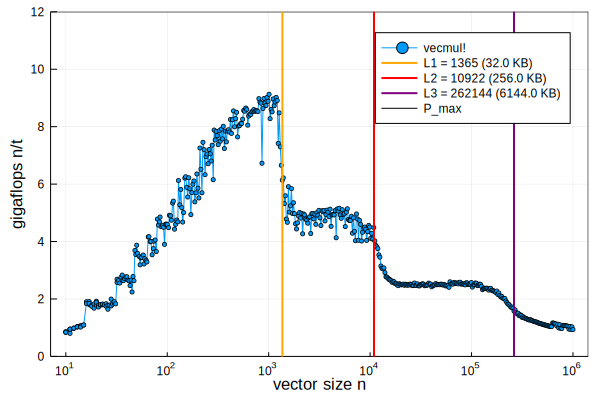

In [297]:
using Plots
plot(N, N ./ t * 1e-9, marker=:circle, label="vecmul!", frame=:box, ms=2, xscale=:log10)
ylabel!("gigaflops n/t")
xlabel!("vector size n")
ylims!(0,12)

L1,L2,L3 = cachesize()
mem = 3*sizeof(Float64) # three arrays, a, b, c
nL1 = L1/mem
nL2 = L2/mem
nL3 = L3/mem
vline!([nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KB)")
vline!([nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KB)")
vline!([nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KB)")

plot!([minimum(N),10^6],[P_max, P_max], color=:black, xscale=:log10, label="P_max")

In [280]:
max_efficiency = round(maximum(N ./ t) * 1e-9 / P_max * 100, digits=1)
println(max_efficiency, "%")

87.8%


## `dot`

In [24]:
function mydot(a,b)
    @assert length(a) == length(b)
    s = zero(eltype(a))
    @inbounds for i in eachindex(a)
        s = s + a[i] * b[i]
    end
    return s
end

mydot (generic function with 1 method)

In [26]:
a = rand(5)
b = rand(5)
mydot(a,b) ≈ dot(a,b)

true

#### Upper performance bound estimate: $P_{max}$

In [291]:
cycles_per_s = cpu_max_frequency() * 1e-3 # 3.9 GHz, assume turbo clock frequency
cycles_necessary = 1 # 2 LOAD, 1 FMA
fma_per_cycle = 2/cycles_necessary
flops_per_fma = 4
flops_per_cycle = flops_per_fma * fma_per_cycle
ncores = 1 # used cores

P_max = cycles_per_s * flops_per_cycle * ncores # Gflops/s

31.2

#### Benchmark

In [27]:
using BenchmarkTools
Ndot = round.(Int, exp10.(range(1, log10(1_000_000), length=100)))
tdot = Float64[]
@time for n in Ndot
    a = fill(1.2, n)
    b = fill(0.8, n)
    push!(tdot, @belapsed dot($a,$b))
    println("finished n = $n, time: ", tdot[end], " flops/t: ", n/tdot[end])
end

finished n = 10, time: 1.4629258517034069e-8 flops/t: 6.835616438356165e8
finished n = 10, time: 1.4328657314629259e-8 flops/t: 6.97902097902098e8
finished n = 10, time: 1.4328657314629259e-8 flops/t: 6.97902097902098e8
finished n = 11, time: 1.533066132264529e-8 flops/t: 7.17516339869281e8
finished n = 11, time: 1.4813813813813815e-8 flops/t: 7.425501723089397e8
finished n = 11, time: 1.5730460921843688e-8 flops/t: 6.99280208930505e8
finished n = 11, time: 1.5530060120240483e-8 flops/t: 7.08303761533002e8
finished n = 12, time: 1.5930861723446894e-8 flops/t: 7.532549216931882e8
finished n = 12, time: 1.5930861723446894e-8 flops/t: 7.532549216931882e8
finished n = 12, time: 1.7034068136272544e-8 flops/t: 7.044705882352942e8
finished n = 13, time: 1.6331663326653305e-8 flops/t: 7.95999754586171e8
finished n = 13, time: 1.6733466933867736e-8 flops/t: 7.768862275449102e8
finished n = 13, time: 1.5630260521042085e-8 flops/t: 8.317199820501313e8
finished n = 13, time: 1.6331663326653305e-8 

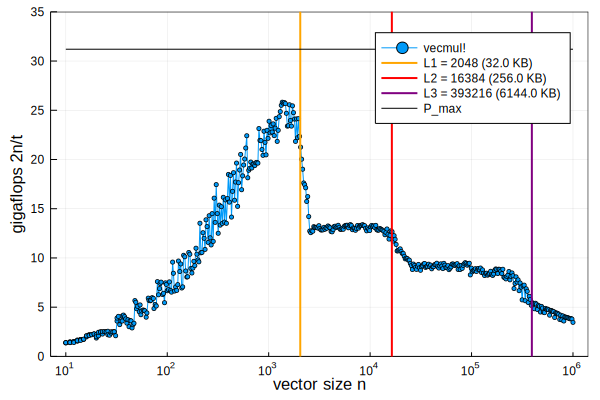

In [296]:
using Plots
plot(N, 2*N ./ tdot * 1e-9, marker=:circle, label="vecmul!", frame=:box, ms=2, xscale=:log10)
ylabel!("gigaflops 2n/t")
xlabel!("vector size n")
ylims!(0,35)

L1,L2,L3 = cachesize()
mem = 2*sizeof(Float64) # two arrays
nL1 = L1/mem
nL2 = L2/mem
nL3 = L3/mem
vline!([nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KB)")
vline!([nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KB)")
vline!([nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KB)")

plot!([minimum(N),10^6],[P_max, P_max], color=:black, xscale=:log10, label="P_max")

In [285]:
max_efficiency = round(maximum(2*N ./ tdot) * 1e-9 / P_max * 100, digits=1)
println(max_efficiency, "%")

82.8%


## `matmul!`

In [2]:
# compute C = A * B, using naive matrix-multiplication algorithm,
# with a pre-allocated output array C.
function matmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    for i = 1:m
        for k = 1:p
            c = zero(eltype(C))
            for j = 1:n
                @inbounds c += A[i,j] * B[j,k]
            end
            @inbounds C[i,k] = c
        end
    end
    return C
end

# a wrapper that allocates C of an appropriate type
matmul(A, B) = matmul!(Matrix{promote_type(eltype(A), eltype(B))}(undef, size(A,1), size(B,2)), A, B)

matmul (generic function with 1 method)

In [3]:
# correctness check:
using LinearAlgebra
A = rand(5,6)
B = rand(6,7)
norm(matmul(A,B) - A * B)

4.710277376051325e-16

In [4]:
# for benchmarking, use only single-threaded BLAS:
BLAS.set_num_threads(1)

In [7]:
using BenchmarkTools
N1 = round.(Int, exp10.(range(1, log10(3000), length=60)))  # 100 sizes from 10 to 3000
t1 = Float64[]
t0 = Float64[]
@time for n in N1
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(t1, @belapsed matmul!($C,$A,$B))
    push!(t0, @belapsed mul!($C,$A,$B))
    println("finished n = $n: slowdown of ", t1[end]/t0[end], " flops/t: ", n/t1[end])
end

finished n = 10: slowdown of 1.6684205163730201 flops/t: 2.0083023633785028e7
finished n = 11: slowdown of 2.032599589723509 flops/t: 1.4535111588895982e7
finished n = 12: slowdown of 2.5959895546247678 flops/t: 1.2857496085057283e7
finished n = 13: slowdown of 2.617432965344241 flops/t: 1.1112060859902555e7
finished n = 15: slowdown of 2.9287562500575515 flops/t: 8.064516129032258e6
finished n = 16: slowdown of 4.642857142857143 flops/t: 7.16417910447761e6
finished n = 18: slowdown of 4.480114722259527 flops/t: 5.6033308689054055e6
finished n = 20: slowdown of 5.352885714285715 flops/t: 4.590314436538903e6
finished n = 22: slowdown of 5.217845030002609 flops/t: 3.6666666666666665e6
finished n = 24: slowdown of 6.617993108664593 flops/t: 3.0477158005016036e6
finished n = 26: slowdown of 6.011667361152449 flops/t: 2.5745123279532627e6
finished n = 29: slowdown of 6.738 flops/t: 1.9864374272210426e6
finished n = 32: slowdown of 8.10385730984025 flops/t: 1.5385355065147365e6
finished n = 

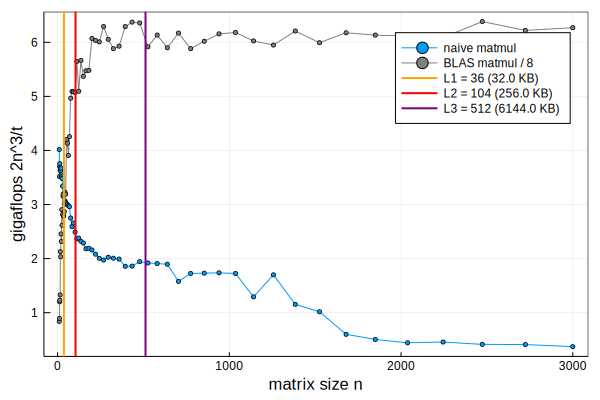

In [302]:
using Plots
plot(N1, 2N1.^3 ./ t1 * 1e-9, marker=:circle, label="naive matmul", frame=:box, ms=2)
plot!(N1, 2N1.^3 ./ t0 * 1e-9 / 8, color=:grey, marker=:circle, label="BLAS matmul / 8", ms=2)
ylabel!("gigaflops 2n^3/t")
xlabel!("matrix size n")

L1,L2,L3 = cachesize()
mem = 3*sizeof(Float64) # two arrays
nL1 = sqrt(L1/mem)
nL2 = sqrt(L2/mem)
nL3 = sqrt(L3/mem)
vline!([nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KB)")
vline!([nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KB)")
vline!([nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KB)")